In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing All Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import RandomSearch
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. Nabil Bank (nabil) Stock Price Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MSc. Dissertation/Dataset/nabil.csv')

In [6]:
df.head()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
0,3/20/2011,"1,200.00","1,190.00","1,160.00","1,170.00",0.0,853,"1,000,811.00"
1,3/24/2011,"1,162.00","1,178.00","1,150.00","1,153.00",0.0,356,"412,649.00"
2,3/25/2011,"1,153.00","1,174.00","1,145.00","1,174.00",0.0,702,"807,507.00"
3,3/27/2011,"1,174.00","1,160.00","1,120.00","1,147.00",0.0,"1,426.00","1,619,270.00"
4,3/28/2011,"1,147.00","1,150.00","1,110.00","1,132.00",0.0,352,"393,534.00"


In [7]:
df.tail()

,Date,Open,High,Low,Ltp,% Change,Qty,Turnover
3078,9/18/2024,562,565,550,556,-0.93,"68,886.00","38,431,118.40"
3079,9/22/2024,556,578,556,562,1.08,"55,026.00","31,054,968.70"
3080,9/23/2024,573.2,573.2,555,568,1.07,"123,568.00","69,577,465.00"
3081,9/24/2024,567,567,552.1,553.5,-2.55,"66,337.00","36,962,336.00"
3082,9/25/2024,550,560,545.1,555,0.27,"50,441.00","27,867,328.70"


In [8]:
df.duplicated().sum()

1

## Copying the dataset for future use

In [9]:
df1 = df.copy()
df1.reset_index(inplace=True)

In [10]:
df.reset_index(drop=True, inplace=True)

### Renaming and Dropping unwanted column

In [11]:
df.drop(['% Change', 'Turnover'], axis=1, inplace=True)
df = df.rename(columns = {
    'Ltp': 'Close',
    'Qty': 'Volume'
})

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float).astype(int)

### Splitting into features and target

In [13]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [14]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [15]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [16]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

In [17]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

### Splitting the data into train and test set

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, y_test_indices = train_test_split(target_index, test_size=0.2, random_state=42)

### Model Building using CNN

In [19]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                  hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='stock_price_tuning',
    project_name='cnn_stock_price')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 10 Complete [00h 01m 14s]
val_loss: 0.000719063071301207

Best val_loss So Far: 0.00035567840677686036
Total elapsed time: 00h 13m 24s


In [20]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparameters.values

{'filters': 128,
 'kernel_size': 3,
 'pool_size': 2,
 'dense_units': 96,
 'dropout': 0.2,
 'learning_rate': 0.0001}

In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

In [22]:
# Make predictions on the test set
predictions = best_model.predict(X_test)
predictions.flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([0.45822382, 0.6718987 , 0.5481852 , 0.6765663 , 0.09172012,
       0.3754781 , 0.59928226, 0.41666716, 0.60287607, 0.43905908,
       0.48650903, 0.07297349, 0.3414811 , 0.4605856 , 0.659608  ,
       0.17486191, 0.81828445, 0.34895504, 0.19113986, 0.80145395,
       0.18306172, 0.12723851, 0.60263926, 0.4400487 , 0.7791771 ,
       0.19574967, 0.08002618, 0.22804895, 0.42885274, 0.12918742,
       0.9243008 , 0.62493145, 0.18711738, 0.44854066, 0.63746643,
       0.22964837, 0.06672421, 0.8036356 , 0.17912805, 0.1530585 ,
       0.25356737, 0.0140796 , 0.49233276, 0.14785795, 0.00676698,
       0.13404338, 0.2951786 , 0.28203037, 0.35752434, 0.5862253 ,
       0.18681504, 0.52900803, 0.4418849 , 0.38175687, 0.5448391 ,
       0.06996337, 0.04048304, 0.37506843, 0.2771078 , 0.24768966,
       0.6546757 , 0.67286426, 0.38486058, 0.55704474, 0.19027305,
       0.9061414 , 0.0142057 , 0.05450049, 0.2981826 , 0.36779508,
       0.65091366, 0.6528617 , 0.14783357, 0.4430623 , 0.21066

In [23]:
y_test

array([0.45017182, 0.66709622, 0.55841924, 0.70575601, 0.09965636,
       0.3685567 , 0.57689003, 0.43939003, 0.5854811 , 0.45532646,
       0.48281787, 0.07310997, 0.33934708, 0.45446735, 0.67353952,
       0.17310997, 0.79381443, 0.34750859, 0.1911512 , 0.80670103,
       0.1774055 , 0.12628866, 0.5661512 , 0.43685567, 0.73152921,
       0.19802405, 0.09750859, 0.22680412, 0.43513746, 0.14175258,
       0.96993127, 0.62414089, 0.18170103, 0.44158076, 0.62285223,
       0.22379725, 0.08891753, 0.81099656, 0.18213058, 0.14067869,
       0.24699313, 0.0270189 , 0.48883162, 0.14390034, 0.00558419,
       0.12843643, 0.31357388, 0.27405498, 0.36297251, 0.5790378 ,
       0.18427835, 0.53221649, 0.43599656, 0.37457045, 0.54080756,
       0.08118557, 0.04338488, 0.37628866, 0.28264605, 0.24140893,
       0.64561856, 0.64561856, 0.36984536, 0.55541237, 0.19630584,
       0.9871134 , 0.01159794, 0.05992268, 0.29424399, 0.39003436,
       0.66065292, 0.65120275, 0.14304124, 0.43857388, 0.20833

In [24]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [25]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df.index:
        if a == b:
            prediction['Date'] = df['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2011-05-11,1070.0,1057.260498
2011-06-02,1056.0,1126.141968
2011-06-14,868.0,982.990417
2011-06-26,1228.0,1093.826538
2011-06-27,1106.0,1227.538452
...,...,...
2024-09-01,595.0,623.532410
2024-09-09,573.0,584.143005
2024-09-11,561.5,548.877136


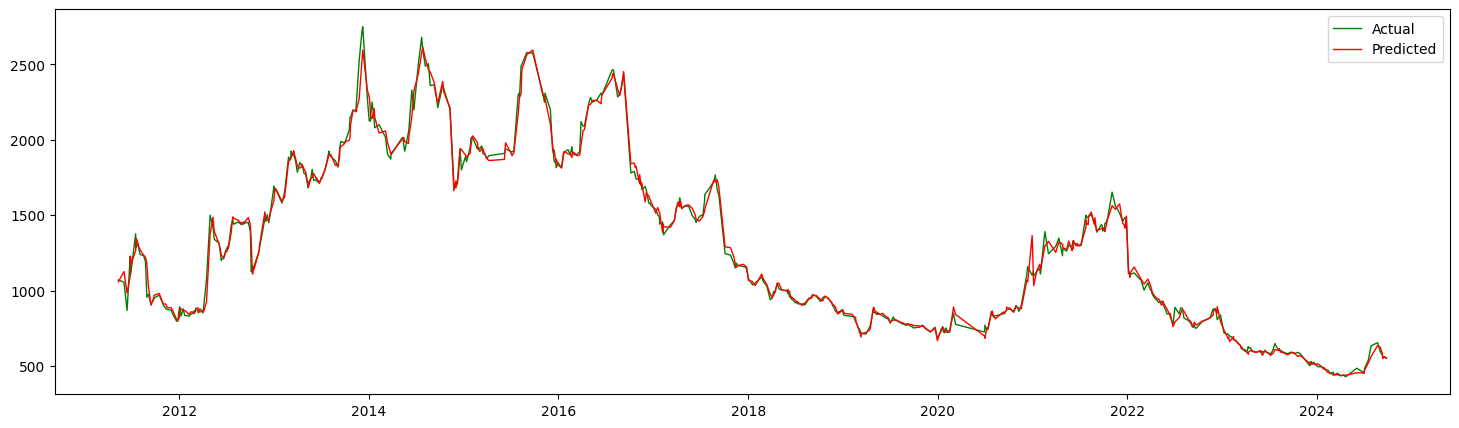

In [26]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [27]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.0003407274391170246
Root Mean Squared Error: 0.018458803837654938
Mean Absolute Error: 0.011505019548398976


In [28]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 1846.6007046280367
Root Mean Squared Error: 42.97209216023857
Mean Absolute Error: 26.783681526745987
